# 3. InceptionResNetV2_SE

## Run name

In [1]:
import time

project_name = 'inclusive-images-challenge'
step_name = '3_InceptionResNetV2_SE'
time_str = time.strftime("%Y%m%d-%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

time0 = time.time()

run_name: inclusive-images-challenge_3_InceptionResNetV2_SE_20181027-030909


## Important params

In [2]:
debug_rows = None #100*10000
image_size = 200
batch_size = 128

print(debug_rows, batch_size)

None 128


## Import pkgs

In [3]:
import os
import random
import time
import re
import math
import pickle
import multiprocessing
from tqdm import tqdm_notebook
from tqdm import tqdm
import imghdr
from functools import partial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, jaccard_similarity_score

cpu_amount = multiprocessing.cpu_count()
random_num = 0 #np.random.randint(0, 9999)
random_num_str = '%04d' % random_num

print('cpu_amount: %s' % (cpu_amount - 1))
print('random_num: %s' % random_num_str)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


cpu_amount: 7
random_num: 0000


## Project folders

In [4]:
cwd = os.getcwd()
feature_folder = os.path.join(cwd, 'feature')
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
log_folder = os.path.join(cwd, 'log')

cwd = os.getcwd()
feature_folder = os.path.join(cwd, 'feature')
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
log_folder = os.path.join(cwd, 'log')

print(feature_folder)
print(input_folder)
print(output_folder)
print(model_folder)
print(log_folder)
train_folder = os.path.join(input_folder, 'train')
validation_folder = os.path.join(input_folder, 'validation')
test_folder = os.path.join(input_folder, 'test')
stage_1_test_images_folder = os.path.join(input_folder, 'stage_1_test_images')
sl_train_folder = os.path.join(input_folder, 'sl_train')
sl_val_folder = os.path.join(input_folder, 'sl_val')
sl_test_folder = os.path.join(input_folder, 'sl_test')

print(train_folder)
print(validation_folder)
print(test_folder)
print(stage_1_test_images_folder)
print(sl_train_folder)
print(sl_val_folder)
print(sl_test_folder)

class_descriptions_csv = os.path.join(input_folder, 'class-descriptions.csv')
class_trainable_csv = os.path.join(input_folder, 'classes-trainable.csv')
stage_1_attributions_csv = os.path.join(input_folder, 'stage_1_attributions.csv')
stage_1_sample_submission_csv = os.path.join(input_folder, 'stage_1_sample_submission.csv')
train_bounding_boxes_csv = os.path.join(input_folder, 'train_bounding_boxes.csv')
train_human_labels_csv = os.path.join(input_folder, 'train_human_labels.csv')
train_machine_labels_csv = os.path.join(input_folder, 'train_machine_labels.csv')
tuning_labels_csv = os.path.join(input_folder, 'tuning_labels.csv')

print(class_descriptions_csv)
print(class_trainable_csv)
print(stage_1_attributions_csv)
print(stage_1_sample_submission_csv)
print(train_bounding_boxes_csv)
print(train_human_labels_csv)
print(train_machine_labels_csv)
print(tuning_labels_csv)

/data/kaggle-Inclusive-Images/feature
/data/kaggle-Inclusive-Images/input
/data/kaggle-Inclusive-Images/output
/data/kaggle-Inclusive-Images/model
/data/kaggle-Inclusive-Images/log
/data/kaggle-Inclusive-Images/input/train
/data/kaggle-Inclusive-Images/input/validation
/data/kaggle-Inclusive-Images/input/test
/data/kaggle-Inclusive-Images/input/stage_1_test_images
/data/kaggle-Inclusive-Images/input/sl_train
/data/kaggle-Inclusive-Images/input/sl_val
/data/kaggle-Inclusive-Images/input/sl_test
/data/kaggle-Inclusive-Images/input/class-descriptions.csv
/data/kaggle-Inclusive-Images/input/classes-trainable.csv
/data/kaggle-Inclusive-Images/input/stage_1_attributions.csv
/data/kaggle-Inclusive-Images/input/stage_1_sample_submission.csv
/data/kaggle-Inclusive-Images/input/train_bounding_boxes.csv
/data/kaggle-Inclusive-Images/input/train_human_labels.csv
/data/kaggle-Inclusive-Images/input/train_machine_labels.csv
/data/kaggle-Inclusive-Images/input/tuning_labels.csv


## Functions

In [5]:
def pickle_dump(obj, file):
    with open(file, 'wb') as f:
        pickle.dump(obj, f)
        
def pickle_load(file):
    with open(file, 'rb') as f:
        obj = pickle.load(f)
        return obj

## Load csv

In [6]:
%%time
# files = list(os.listdir(train_folder))
# print(len(files))
# print(files[:10])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [7]:
%%time
train_bounding_boxes_df = pd.read_csv(train_bounding_boxes_csv, nrows=debug_rows)

CPU times: user 19.2 s, sys: 1.6 s, total: 20.8 s
Wall time: 1min 2s


In [8]:
# %%time
# train_machine_labels_df = pd.read_csv(train_machine_labels_csv)

In [9]:
# %%time
# train_human_labels_df = pd.read_csv(train_human_labels_csv)

In [10]:
%%time
stage_1_attributions_df = pd.read_csv(stage_1_attributions_csv)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 58.5 ms


In [11]:
%%time
stage_1_sample_submission_df = pd.read_csv(stage_1_sample_submission_csv)

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 43.9 ms


In [12]:
display('train_bounding_boxes_df', train_bounding_boxes_df.shape, train_bounding_boxes_df.head(2))
# display('train_machine_labels_df', train_machine_labels_df.shape, train_machine_labels_df.head(2))
# display('train_human_labels_df', train_human_labels_df.shape, train_human_labels_df.head(2))
display('stage_1_attributions_df', stage_1_attributions_df.shape, stage_1_attributions_df.head(2))
display('stage_1_sample_submission_df', stage_1_sample_submission_df.shape, stage_1_sample_submission_df.head(2))

'train_bounding_boxes_df'

(14610229, 13)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.0125,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.0250,0.276563,0.714063,0.948438,0,1,0,0,0


'stage_1_attributions_df'

(32580, 2)

,image_id,source
0,2b2b327132556c767a736b3d,Nita Ar
1,2b2b394755692f303963553d,Sathya Esarapu


'stage_1_sample_submission_df'

(32580, 2)

,image_id,labels
0,2b2b327132556c767a736b3d,/m/0sgh53y /m/0g4cd0
1,2b2b394755692f303963553d,/m/0sgh53y /m/0g4cd0


In [13]:
print(len(set(train_bounding_boxes_df['LabelName'])), '--> Use this 599 labels, approximate 600 labels')
# print(len(set(train_machine_labels_df['LabelName'])))
# print(len(set(train_human_labels_df['LabelName'])))
# print(len(set(stage_1_sample_submission_df['labels'])))

599 --> Use this 599 labels, approximate 600 labels


In [34]:
# labels = list(set(train_bounding_boxes_df['LabelName']))
# len_labels = len(labels)
# print(len_labels)
# label2num = {}
# num2label = {}
# for i, label in enumerate(labels):
#     label2num[label] = i
#     num2label[i] = label
# print(label2num)
# print(num2label)
# 
# tag_info = {}
# tag_info['label2num'] = label2num
# tag_info['num2label'] = num2label

In [35]:
# taginfo_file = os.path.join(model_folder, run_name + '_tag_info.pkl')
# print(taginfo_file)
# pickle_dump(tag_info, taginfo_file)
# tag_info1 = pickle_load(taginfo_file)
# print(tag_info1.keys())

## Split

In [16]:
%%time

data_ids = list(set(train_bounding_boxes_df['ImageID']))
train_ids, val_ids = train_test_split(data_ids, test_size=0.05, random_state=random_num)
print('len(data_ids):\t', len(data_ids))
print('len(train_ids):\t%s\t' % len(train_ids), len(train_ids)/len(data_ids))
print('len(val_ids):\t%s\t' % len(val_ids), len(val_ids)/len(data_ids))
train_id_set = set(train_ids)
val_id_set = set(val_ids)

train_df = train_bounding_boxes_df[train_bounding_boxes_df['ImageID'].apply(lambda x: x in train_id_set)]
val_df = train_bounding_boxes_df[train_bounding_boxes_df['ImageID'].apply(lambda x: x in val_id_set)]
print('train_df.shape:\t', train_df.shape, '\t', train_df.shape[0]/train_bounding_boxes_df.shape[0])
print('val_df.shape:\t', val_df.shape, '\t\t', val_df.shape[0]/train_bounding_boxes_df.shape[0])

len(data_ids):	 1743042
len(train_ids):	1655889	 0.9499994836613231
len(val_ids):	87153	 0.050000516338676866
train_df.shape:	 (13883273, 13) 	 0.9502433534751578
val_df.shape:	 (726956, 13) 		 0.04975664652484229
CPU times: user 8.4 s, sys: 384 ms, total: 8.79 s
Wall time: 8.87 s


## Create train validation test soft link

In [17]:
# %%time
# !rm -rf /data/kaggle-Inclusive-Images/input/sl_train
# !rm -rf /data/kaggle-Inclusive-Images/input/sl_val
# !rm -rf /data/kaggle-Inclusive-Images/input/sl_test

In [18]:
%%time
def create_soft_link(df, label2num, source_folder, target_folder):
    print(source_folder, target_folder)
    # Create target_folder
    if not os.path.exists(target_folder):
        os.mkdir(target_folder)
        print('Create folder:\t', target_folder)
        # Create sub_class_folder
        for label in label2num.keys():
            sub_folder = os.path.join(target_folder, label.replace('/', '-'))
            os.mkdir(sub_folder)
            print('Create sub folder:\t', sub_folder)
    else:
        print('Exists folder:\t', target_folder)
        return

#     pool = multiprocessing.Pool(cpu_amount)
#     for row in tqdm_notebook(pool.imap_unordered(myfunc, range(100)), total=100):
    time.sleep(1) # Wait to print message
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
#         print(type(row))
#     for i, row in df.iterrows():
#         if i >= 5:
#             break
        src_img = os.path.join(source_folder, '%s.jpg' % row['ImageID'])
        target_img = os.path.join(target_folder, row['LabelName'].replace('/', '-'), '%s.jpg' % row['ImageID'])
#         print(src_img)
#         print(target_img)
        if not os.path.exists(target_img):
            if imghdr.what(src_img):
                os.symlink(src_img, target_img)
            else:
                print('Image error:', src_img)
#             print('Created file:', target_img)
#         else:
#             print('Existed file:', target_img)
    
create_soft_link(train_df, label2num, train_folder, sl_train_folder)
create_soft_link(val_df, label2num, train_folder, sl_val_folder)

/data/kaggle-Inclusive-Images/input/train /data/kaggle-Inclusive-Images/input/sl_train
Exists folder:	 /data/kaggle-Inclusive-Images/input/sl_train
/data/kaggle-Inclusive-Images/input/train /data/kaggle-Inclusive-Images/input/sl_val
Exists folder:	 /data/kaggle-Inclusive-Images/input/sl_val
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.31 ms


In [19]:
%%time
def create_test_soft_link(df, source_folder, target_folder):
    print(source_folder, target_folder)
    # Create target_folder
    if not os.path.exists(target_folder):
        os.mkdir(target_folder)
        print('Create folder:\t', target_folder)
        # Create sub_class_folder
        sub_folder = os.path.join(target_folder, 'test')
        os.mkdir(sub_folder)
        print('Create sub folder:\t', sub_folder)
    else:
        print('Exists folder:\t', target_folder)
        return

#     pool = multiprocessing.Pool(cpu_amount)
#     for row in tqdm_notebook(pool.imap_unordered(myfunc, range(100)), total=100):
    time.sleep(1) # Wait to print message
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
#         print(type(row))
#     for i, row in df.iterrows():
#         if i >= 5:
#             break
        src_img = os.path.join(source_folder, '%s.jpg' % row['image_id'])
        target_img = os.path.join(target_folder, 'test', '%s.jpg' % row['image_id'])
#         print(src_img)
#         print(target_img)
        if os.path.exists(src_img) and not os.path.exists(target_img):
            if imghdr.what(src_img):
                os.symlink(src_img, target_img)
            else:
                print('Image error:', src_img)
#             print('Created file:', target_img)
#         else:
#             print('Existed file:', target_img)
    
create_test_soft_link(stage_1_attributions_df, stage_1_test_images_folder, sl_test_folder)

/data/kaggle-Inclusive-Images/input/stage_1_test_images /data/kaggle-Inclusive-Images/input/sl_test
Exists folder:	 /data/kaggle-Inclusive-Images/input/sl_test
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.58 ms


## Build model

In [20]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.utils import Sequence
from keras import backend as K

from skimage.io import imread
from skimage.transform import resize

Using TensorFlow backend.


In [21]:
# print(sl_train_folder)

In [22]:
%%time
gen = ImageDataGenerator(
    zoom_range = 0.1,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    rotation_range = 10
)
train_generator = gen.flow_from_directory(
    sl_train_folder, 
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = gen.flow_from_directory(
    sl_val_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator  = gen.flow_from_directory(
    sl_test_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4202018 images belonging to 599 classes.
Found 221475 images belonging to 599 classes.
Found 32536 images belonging to 1 classes.
CPU times: user 6min 48s, sys: 15.8 s, total: 7min 4s
Wall time: 2h 21min 57s


In [32]:
print(train_generator.filenames[:5])
print(train_generator.class_indices)
print(val_generator.filenames[:5])
print(val_generator.class_indices)
print(test_generator.filenames[:5])
print(test_generator.class_indices)

['-m-011k07/000aee0af66d4237.jpg', '-m-011k07/001ef0f9885fa3d4.jpg', '-m-011k07/00a5bf99b538fa23.jpg', '-m-011k07/00ba381a304dd39d.jpg', '-m-011k07/00c0a7bf94467de6.jpg']
{'-m-011k07': 0, '-m-012074': 1, '-m-0120dh': 2, '-m-01226z': 3, '-m-012n7d': 4, '-m-012w5l': 5, '-m-012xff': 6, '-m-012ysf': 7, '-m-0130jx': 8, '-m-0138tl': 9, '-m-013y1f': 10, '-m-01432t': 11, '-m-014j1m': 12, '-m-014sv8': 13, '-m-014trl': 14, '-m-014y4n': 15, '-m-0152hh': 16, '-m-01599': 17, '-m-015h_t': 18, '-m-015p6': 19, '-m-015qbp': 20, '-m-015qff': 21, '-m-015wgc': 22, '-m-015x4r': 23, '-m-015x5n': 24, '-m-0162_1': 25, '-m-0167gd': 26, '-m-016m2d': 27, '-m-0174k2': 28, '-m-0174n1': 29, '-m-0175cv': 30, '-m-0176mf': 31, '-m-017ftj': 32, '-m-018j2': 33, '-m-018p4k': 34, '-m-018xm': 35, '-m-01940j': 36, '-m-0199g': 37, '-m-019dx1': 38, '-m-019h78': 39, '-m-019jd': 40, '-m-019w40': 41, '-m-01_5g': 42, '-m-01_bhs': 43, '-m-01b638': 44, '-m-01b7fy': 45, '-m-01b9xk': 46, '-m-01bfm9': 47, '-m-01bjv': 48, '-m-01bl7v': 

In [33]:
print(test_generator.classes)
for train_c, val_c in zip(train_generator.class_indices, val_generator.class_indices):
    print(train_c, val_c)
    assert train_c == val_c, 'train class order should equal to val class order'

[0 0 0 ... 0 0 0]
-m-011k07 -m-011k07
-m-012074 -m-012074
-m-0120dh -m-0120dh
-m-01226z -m-01226z
-m-012n7d -m-012n7d
-m-012w5l -m-012w5l
-m-012xff -m-012xff
-m-012ysf -m-012ysf
-m-0130jx -m-0130jx
-m-0138tl -m-0138tl
-m-013y1f -m-013y1f
-m-01432t -m-01432t
-m-014j1m -m-014j1m
-m-014sv8 -m-014sv8
-m-014trl -m-014trl
-m-014y4n -m-014y4n
-m-0152hh -m-0152hh
-m-01599 -m-01599
-m-015h_t -m-015h_t
-m-015p6 -m-015p6
-m-015qbp -m-015qbp
-m-015qff -m-015qff
-m-015wgc -m-015wgc
-m-015x4r -m-015x4r
-m-015x5n -m-015x5n
-m-0162_1 -m-0162_1
-m-0167gd -m-0167gd
-m-016m2d -m-016m2d
-m-0174k2 -m-0174k2
-m-0174n1 -m-0174n1
-m-0175cv -m-0175cv
-m-0176mf -m-0176mf
-m-017ftj -m-017ftj
-m-018j2 -m-018j2
-m-018p4k -m-018p4k
-m-018xm -m-018xm
-m-01940j -m-01940j
-m-0199g -m-0199g
-m-019dx1 -m-019dx1
-m-019h78 -m-019h78
-m-019jd -m-019jd
-m-019w40 -m-019w40
-m-01_5g -m-01_5g
-m-01_bhs -m-01_bhs
-m-01b638 -m-01b638
-m-01b7fy -m-01b7fy
-m-01b9xk -m-01b9xk
-m-01bfm9 -m-01bfm9
-m-01bjv -m-01bjv
-m-01bl7v -m-01bl7

In [42]:
tag_info = {}
tag_info['train_class_indices'] = train_generator.class_indices
tag_info['val_class_indices'] = val_generator.class_indices
tag_info['test_class_indices'] = test_generator.class_indices

In [43]:
taginfo_file = os.path.join(model_folder, run_name + '_tag_info.pkl')
print(taginfo_file)
pickle_dump(tag_info, taginfo_file)
tag_info1 = pickle_load(taginfo_file)
print(tag_info1.keys())

/data/kaggle-Inclusive-Images/model/inclusive-images-challenge_3_InceptionResNetV2_SE_20181027-030909_tag_info.pkl
dict_keys(['train_class_indices', 'val_class_indices', 'test_class_indices'])


In [44]:
display(tag_info1['train_class_indices'])

{'-m-011k07': 0,
 '-m-012074': 1,
 '-m-0120dh': 2,
 '-m-01226z': 3,
 '-m-012n7d': 4,
 '-m-012w5l': 5,
 '-m-012xff': 6,
 '-m-012ysf': 7,
 '-m-0130jx': 8,
 '-m-0138tl': 9,
 '-m-013y1f': 10,
 '-m-01432t': 11,
 '-m-014j1m': 12,
 '-m-014sv8': 13,
 '-m-014trl': 14,
 '-m-014y4n': 15,
 '-m-0152hh': 16,
 '-m-01599': 17,
 '-m-015h_t': 18,
 '-m-015p6': 19,
 '-m-015qbp': 20,
 '-m-015qff': 21,
 '-m-015wgc': 22,
 '-m-015x4r': 23,
 '-m-015x5n': 24,
 '-m-0162_1': 25,
 '-m-0167gd': 26,
 '-m-016m2d': 27,
 '-m-0174k2': 28,
 '-m-0174n1': 29,
 '-m-0175cv': 30,
 '-m-0176mf': 31,
 '-m-017ftj': 32,
 '-m-018j2': 33,
 '-m-018p4k': 34,
 '-m-018xm': 35,
 '-m-01940j': 36,
 '-m-0199g': 37,
 '-m-019dx1': 38,
 '-m-019h78': 39,
 '-m-019jd': 40,
 '-m-019w40': 41,
 '-m-01_5g': 42,
 '-m-01_bhs': 43,
 '-m-01b638': 44,
 '-m-01b7fy': 45,
 '-m-01b9xk': 46,
 '-m-01bfm9': 47,
 '-m-01bjv': 48,
 '-m-01bl7v': 49,
 '-m-01bms0': 50,
 '-m-01bqk0': 51,
 '-m-01btn': 52,
 '-m-01c648': 53,
 '-m-01cmb2': 54,
 '-m-01d380': 55,
 '-m-01d40f

In [45]:
batch_data = next(train_generator)
print(batch_data[0].shape, batch_data[1].shape)
batch_data = next(val_generator)
print(batch_data[0].shape, batch_data[1].shape)

(128, 200, 200, 3) (128, 599)
(128, 200, 200, 3) (128, 599)


In [46]:
steps_per_epoch = 2000 #math.ceil(train_df.shape[0]/batch_size) # 2000 images/hour
validation_steps = 2000 #math.ceil(val_df.shape[0]/batch_size)
print('steps_per_epoch:\t', steps_per_epoch)
print('validation_steps:\t', validation_steps)

steps_per_epoch:	 2000
validation_steps:	 2000


In [53]:
# def get_lr(x):
#     lr = round(3e-4 * 0.98 ** x, 6)
#     if lr < 1e-5:
#         lr = 1e-5
#     print(lr, end='  ')
#     return lr

def get_lr(x):
    if x <= 5:
        lr = 1e-3
    elif x <= 10:
        lr = 1e-4
    else:
        lr = 1e-5
    print('%s ' % lr, end='')
    return lr
[get_lr(i) for i in range(30)]

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

callbacks = [annealer]

0.001 0.001 0.001 0.001 0.001 0.001 0.0001 0.0001 0.0001 0.0001 0.0001 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 1e-05 

In [54]:
# create the base pre-trained model
# base_model = VGG16(weights=None, include_top=False) # For debug
base_model = InceptionResNetV2(weights=None, include_top=False) # Rule do not allow default weight

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(len_labels, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = True

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_339 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_339 (BatchN (None, None, None, 3 96          conv2d_339[0][0]                 
__________________________________________________________________________________________________
activation_338 (Activation)     (None, None, None, 3 0           batch_normalization_339[0][0]    
__________________________________________________________________________________________________
conv2d_340

In [56]:
# train the model on the new data for a few epochs
hist = model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=15, 
    verbose=1, 
    callbacks=callbacks, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    max_queue_size=batch_size, 
    workers=cpu_amount, 
    use_multiprocessing=False, 
    shuffle=True, 
    initial_epoch=0
)

Epoch 1/15
2000/2000 [==============================] - 3636s 2s/step - loss: 3.7913 - acc: 0.1504 - val_loss: 3.6764 - val_acc: 0.1568
Epoch 2/15
2000/2000 [==============================] - 3602s 2s/step - loss: 3.4480 - acc: 0.1805 - val_loss: 3.6353 - val_acc: 0.1611
Epoch 3/15
2000/2000 [==============================] - 3518s 2s/step - loss: 3.3069 - acc: 0.1917 - val_loss: 3.3626 - val_acc: 0.1865
Epoch 4/15
2000/2000 [==============================] - 3540s 2s/step - loss: 3.2262 - acc: 0.1994 - val_loss: 3.2001 - val_acc: 0.2024
Epoch 5/15
2000/2000 [==============================] - 3507s 2s/step - loss: 3.1565 - acc: 0.2037 - val_loss: 3.6199 - val_acc: 0.1688
Epoch 6/15
2000/2000 [==============================] - 3521s 2s/step - loss: 3.1791 - acc: 0.2019 - val_loss: 3.3807 - val_acc: 0.1811
Epoch 7/15
1633/2000 [=======================>......] - ETA: 5:54 - loss: 3.0833 - acc: 0.2137

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3263561744 bytes but only got 0. Skipping tag 8
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2284257280 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2284978176 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19600506880 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, 

2000/2000 [==============================] - 3530s 2s/step - loss: 3.0731 - acc: 0.2143 - val_loss: 3.0412 - val_acc: 0.2183
Epoch 8/15
2000/2000 [==============================] - 3517s 2s/step - loss: 3.0094 - acc: 0.2199 - val_loss: 3.0065 - val_acc: 0.2214
Epoch 9/15
2000/2000 [==============================] - 3531s 2s/step - loss: 2.9864 - acc: 0.2222 - val_loss: 2.9770 - val_acc: 0.2242
Epoch 10/15
1925/2000 [===========================>..] - ETA: 1:13 - loss: 2.9618 - acc: 0.2242

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3263561744 bytes but only got 0. Skipping tag 8
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2284257280 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2284978176 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19600506880 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, 

2000/2000 [==============================] - 3544s 2s/step - loss: 2.9597 - acc: 0.2245 - val_loss: 2.9665 - val_acc: 0.2266
Epoch 11/15
2000/2000 [==============================] - 3545s 2s/step - loss: 2.9435 - acc: 0.2269 - val_loss: 2.9556 - val_acc: 0.2292
Epoch 12/15
2000/2000 [==============================] - 3528s 2s/step - loss: 2.9322 - acc: 0.2281 - val_loss: 2.9469 - val_acc: 0.2294
Epoch 13/15
2000/2000 [==============================] - 3565s 2s/step - loss: 2.9330 - acc: 0.2275 - val_loss: 2.9429 - val_acc: 0.2301
Epoch 14/15
2000/2000 [==============================] - 3533s 2s/step - loss: 2.9264 - acc: 0.2278 - val_loss: 2.9361 - val_acc: 0.2307
Epoch 15/15
1227/2000 [=================>............] - ETA: 12:26 - loss: 2.9182 - acc: 0.2303

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3263561744 bytes but only got 0. Skipping tag 8
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2284257280 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2284978176 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19600506880 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, 

2000/2000 [==============================] - 3562s 2s/step - loss: 2.9215 - acc: 0.2303 - val_loss: 2.9403 - val_acc: 0.2308


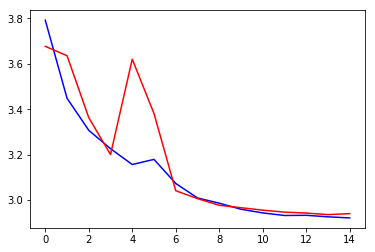

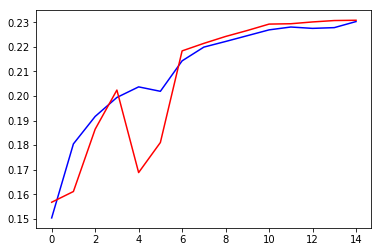

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [58]:
%%time
final_loss, final_acc = model.evaluate_generator(
    val_generator,
    max_queue_size=batch_size,
    workers=cpu_amount,
    use_multiprocessing=False,
    steps=1000,
    verbose=1
)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

1000/1000 [==============================] - 715s 715ms/step
Final loss: 2.9340, final accuracy: 0.2301
CPU times: user 1h 22min 7s, sys: 1min 57s, total: 1h 24min 5s
Wall time: 11min 55s


In [59]:
run_name_acc = run_name + '_%04d' % (final_acc*10000)
print(run_name_acc)

inclusive-images-challenge_3_InceptionResNetV2_SE_20181027-030909_2301


In [60]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_folder, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'lr', 'val_acc', 'val_loss', 'epoch'], dtype='object')


In [61]:
weigthsFile = os.path.join(model_folder, run_name_acc + '.h5')
print(weigthsFile)
model.save(weigthsFile)

/data/kaggle-Inclusive-Images/model/inclusive-images-challenge_3_InceptionResNetV2_SE_20181027-030909_2301.h5


In [62]:
print('Time cost: %.2f' % (time.time() - time0))

print(run_name_acc)
print('Done !')

Time cost: 68166.52
inclusive-images-challenge_3_InceptionResNetV2_SE_20181027-030909_2301
Done !
